In [1]:
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

        y      k
0   276.7  10.76
1   293.6  11.52
2   303.7  11.92
3   303.2  10.20
4   306.7  10.21
..    ...    ...
76  321.4  10.46
77  313.7  10.16
78  283.9  10.23
79  318.6  12.40
80  322.3  10.81

[81 rows x 2 columns]


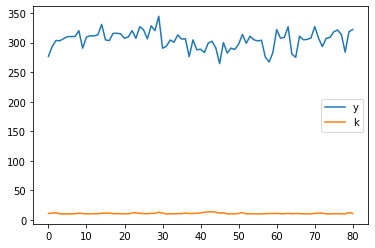

In [2]:
df = pd.read_csv('../Dataset/training_data.csv',encoding='unicode_escape')
df.columns = ['Date','y','k']
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])

#Variables for training
cols = list(df)[1:]

df_for_training = df[cols].astype(float)
print(df_for_training)
df_for_training.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [3]:
print(df_for_training_scaled)

[[-1.83027977 -0.12719633]
 [-0.71395916  0.77282739]
 [-0.04680897  1.24652408]
 [-0.07983621 -0.79037171]
 [ 0.15135445 -0.77852929]
 [ 0.38254511 -0.75484446]
 [ 0.38254511 -0.82589896]
 [ 0.40236145 -0.77852929]
 [ 1.04308985  0.64256079]
 [-0.91212258 -0.24562051]
 [ 0.32309608 -0.93248072]
 [ 0.47502137 -0.82589896]
 [ 0.46181048 -0.57720819]
 [ 0.58070853 -0.51799611]
 [ 1.75647817  0.39387003]
 [ 0.01264005  0.42939728]
 [-0.06001987  0.58334871]
 [ 0.74584471 -0.3758871 ]
 [ 0.75905561 -0.39957193]
 [ 0.69300114 -0.43509919]
 [ 0.19759258 -0.84958379]
 [ 0.34951787 -0.68378995]
 [ 1.0496953   1.06888782]
 [ 0.19098713  1.28205133]
 [ 1.48565482  0.12149443]
 [ 1.15538245 -0.13903875]
 [ 0.13153811 -0.60089303]
 [ 1.59794743  0.29913069]
 [ 1.0496953   0.08596718]
 [ 2.66142446  2.44260823]
 [-0.91212258  0.64256079]
 [-0.70074827 -0.88511105]
 [ 0.00603461 -0.74300204]
 [-0.25157784 -0.84958379]
 [ 0.58070853 -0.36404468]
 [ 0.10511632 -0.49431127]
 [ 0.144749    0.73730013]
 

In [4]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).
trainX = []
trainY = []

n_future = 7   # Number of days we want to predict into the future
n_past = 28     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (47, 28, 2).
trainY shape == (47, 1).


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 28, 64)            17152     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
3/3 [==============================] - 2s 215ms/step - loss: 1.1186 - val_loss: 1.2100
Epoch 2/30
3/3 [==============================] - 0s 40ms/step - loss: 1.0392 - val_loss: 1.2744
Epoch 3/30
3/3 [==============================] - 0s 40

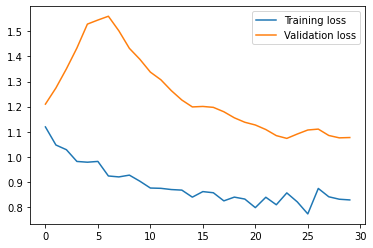

In [5]:

# define Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit model
history = model.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [6]:

#Forecasting...
#Start with the last day in training date and predict future...
n_future=8  #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:]) #forecast 

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]


<AxesSubplot:xlabel='Date', ylabel='y'>

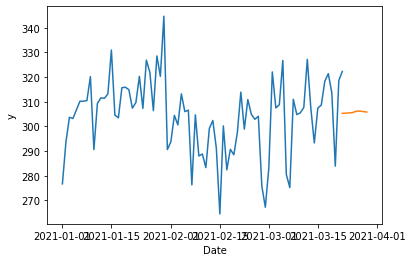

In [7]:

# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'y':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'y']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['y'])
sns.lineplot(df_forecast['Date'], df_forecast['y'])

In [8]:
print(original['Date'], original['y'])

0    2021-01-01
1    2021-01-02
2    2021-01-03
3    2021-01-04
4    2021-01-05
        ...    
76   2021-03-18
77   2021-03-19
78   2021-03-20
79   2021-03-21
80   2021-03-22
Name: Date, Length: 81, dtype: datetime64[ns] 0     276.7
1     293.6
2     303.7
3     303.2
4     306.7
      ...  
76    321.4
77    313.7
78    283.9
79    318.6
80    322.3
Name: y, Length: 81, dtype: float64


In [9]:
print(df_forecast['Date'], df_forecast['y'])

0   2021-03-22
1   2021-03-23
2   2021-03-24
3   2021-03-25
4   2021-03-26
5   2021-03-27
6   2021-03-28
7   2021-03-29
Name: Date, dtype: datetime64[ns] 0    305.297455
1    305.385590
2    305.484375
3    305.625854
4    306.181946
5    306.235596
6    306.005310
7    305.830322
Name: y, dtype: float32
